En este archivo se explica e implementa el proceso de calcular las líneas del carríl por el que va nuestro coche

In [354]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

CWD = os.getcwd()
PATH_CITYSCAPE_DATA = os.path.join(CWD, 'datasets/cityscape_data')
PATH_IMAGES = os.path.join(CWD, "display_elements/road_segmentation/images")
PATH_VIDEOS = os.path.join(CWD, "display_elements/road_segmentation/videos")
PATH_RESULT_IMAGES = os.path.join(CWD, "results/road_segmentation/images")
PATH_RESULT_VIDEOS = os.path.join(CWD, "results/road_segmentation/videos")

try:
    os.mkdir(PATH_RESULT_IMAGES)
    os.mkdir(PATH_RESULT_VIDEOS)
except FileExistsError:
    pass

print(f"Dataset: {PATH_CITYSCAPE_DATA}")
print(f"Images: {PATH_IMAGES}")
print(f"Videos: {PATH_VIDEOS}")
print(f"Resulting images: {PATH_RESULT_IMAGES}")
print(f"Resulting videos: {PATH_RESULT_VIDEOS}")

Dataset: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\datasets/cityscape_data
Images: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\display_elements/road_segmentation/images
Videos: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\display_elements/road_segmentation/videos
Resulting images: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/road_segmentation/images
Resulting videos: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/road_segmentation/videos


Para reflejar los diferentes pasos, se va a aplicar la detección de líneas a una imagend ejemplo.

img_h: 835 x img_w:1813


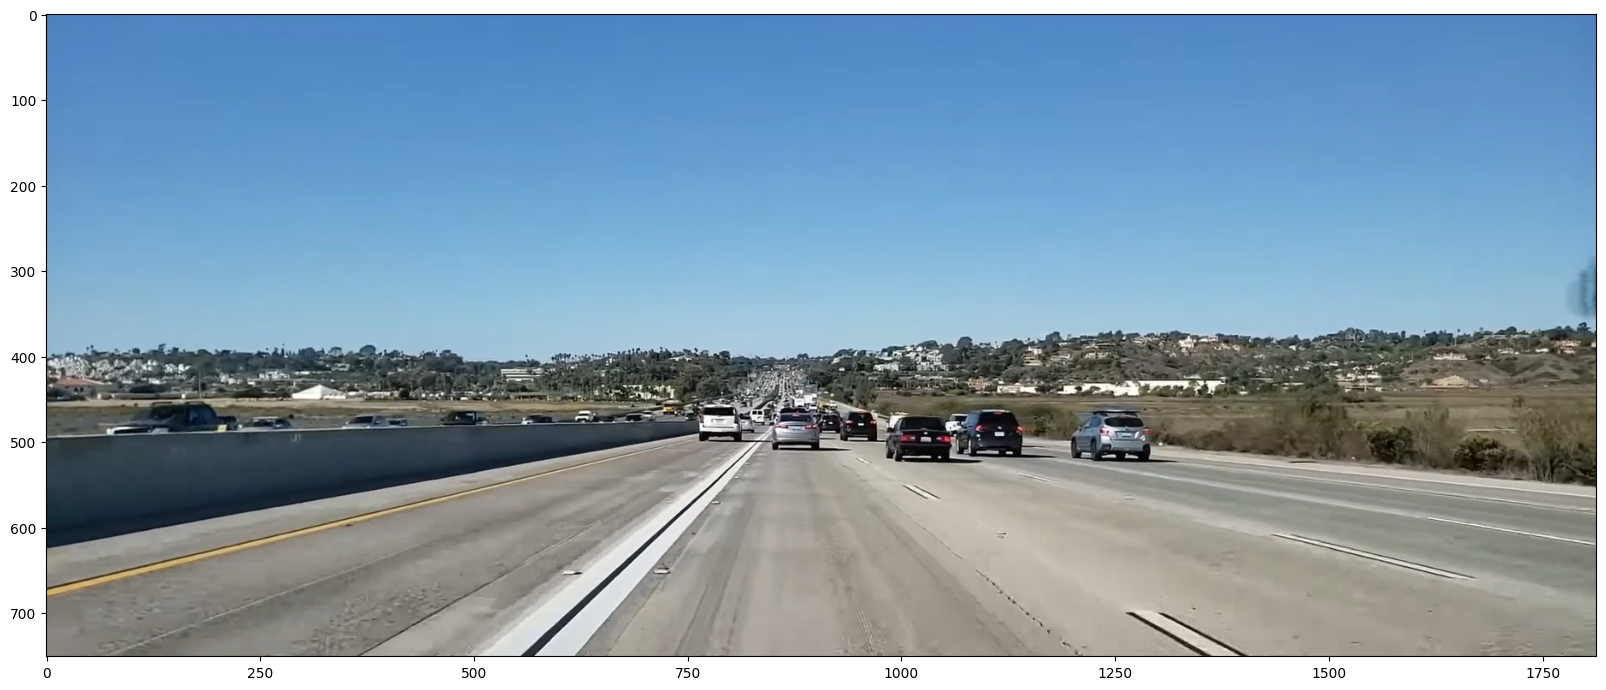

In [355]:
# Get the road image
image_name = "road1.png"
img_path = os.path.join(PATH_IMAGES, image_name)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

img_h, img_w = image.shape[:2]

image = image[:int(img_h*0.9)]

print(f"img_h: {img_h} x img_w:{img_w}")
plt.figure(figsize=(20, 14))
plt.imshow(image)

# MÉTODO CON CANNY

## Calculo de imagen de bordes

El primer paso es calcular los bordes de la imagen, entre los que se encontrarán las líneas. Estas serán de los elementos de la imagen con mayor gradiente en el eje X, ya que el contraste de color entre las líneas y el asfalto suele ser muy elevado, y su dirección es vertical en la imagen.

A continuación se implementa una función que devuelve la imagen de bordes utilizando Canny.

In [356]:
def image_edges(image, lower_threshold, upper_threshold):
    """ Apply Canny algorithm to an image.   
    
        Args:
            image: Input image to be binarized
            lower_threshold: bottom value for hysteresis
            upper_threshold: top value for hysteresis
        Returns: 
            canny: Canny output image
    """  
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred_img = cv2.GaussianBlur(gray, (7,7), 1)
    canny = cv2.Canny(blurred_img,lower_threshold,upper_threshold)
    
    return canny

A continuación se aplica la detección de bordes a la imagen de muestra

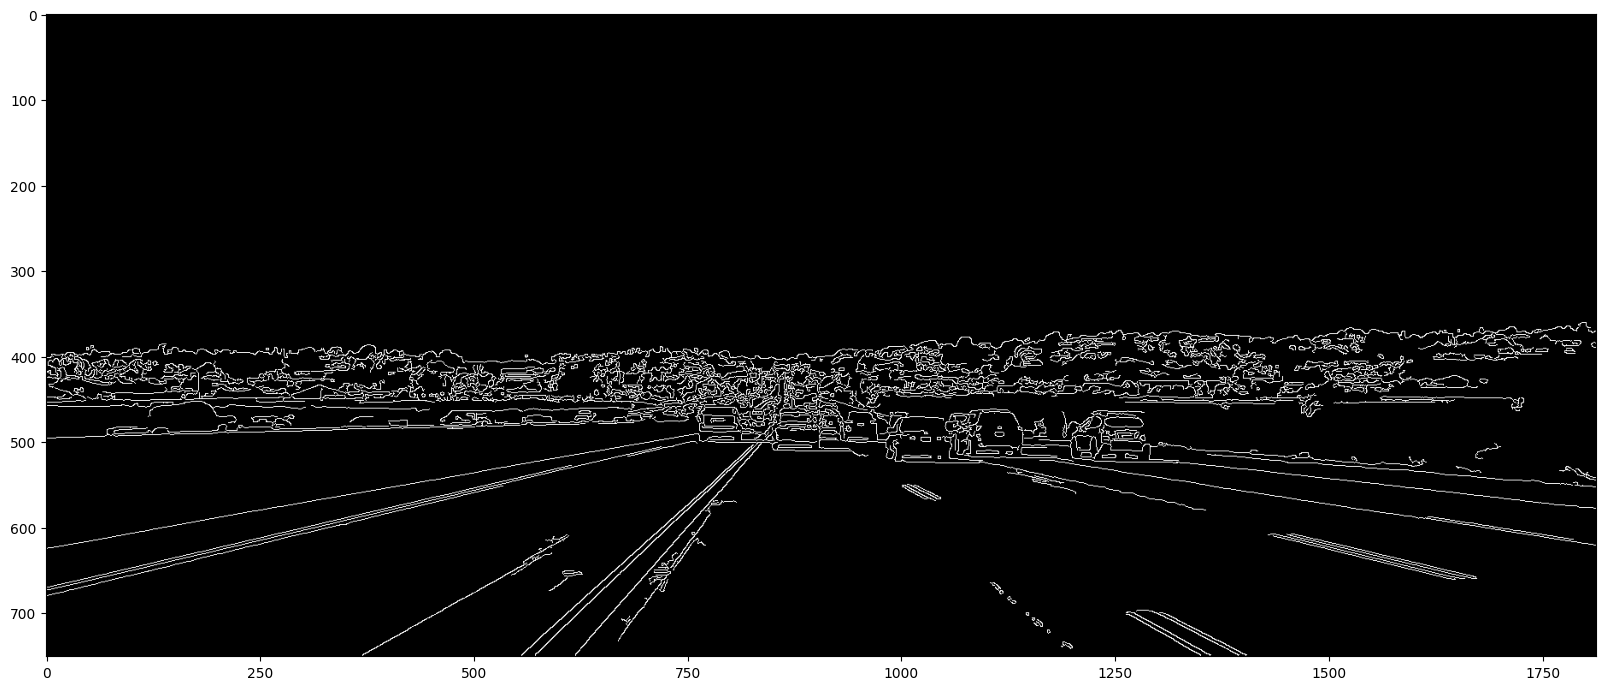

In [357]:
edges = image_edges(image, lower_threshold=5, upper_threshold=250)

plt.figure(figsize=(20, 14))
plt.imshow(edges, cmap='gray')

## Eliminar perspectiva

El siguiente paso, es eliminar la perspectiva que presenta la imagen, y dejar el carril "visto desde arriba". Para ello, se debe averiguar la homografía que hay que aplicar.

Para poder aproximar una homografía común a todas las imágenes de carretera tomada por una cámara en un vehículo, se analizará una imagen de muestra de una carretera recta. En esta imagen, se va a suponer que existe un rectángulo alineado con las líneas del carril, que se utilizará para averiguar la homografía que corregirá la perspectiva.

A continuación se muestra la imagen de muestra, con el rectángulo imaginario dibujado sobre la carretera.

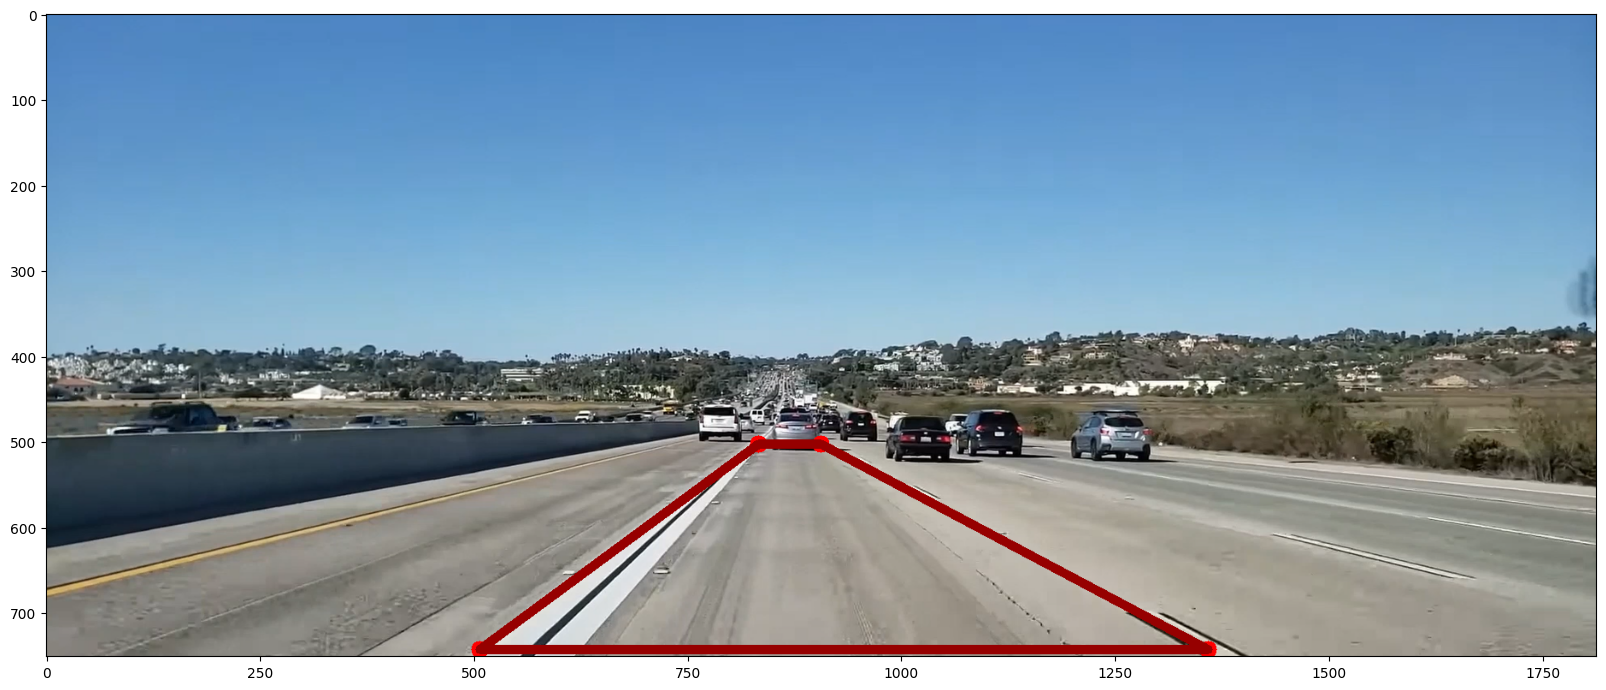

In [358]:
# Image height and width
img_h, img_w = image.shape[:2]

# Define the rectangle for the image perspective
p1_top_left = (int(img_w * 0.46), int(img_h * 0.67)) 
p2_top_right = (int(img_w * 0.50), int(img_h * 0.67)) 
p3_bot_right = (int(img_w * 0.75), int(img_h * 0.99)) 
p4_bot_left  = (int(img_w * 0.28), int(img_h * 0.99)) 

src_pts = np.float32([p1_top_left, p2_top_right, p3_bot_right, p4_bot_left])
draw_pts = src_pts.astype(int)

image_rectangle = image.copy()

for point in draw_pts:
    cv2.circle(image_rectangle, (point[0], point[1]), 10, (255, 0, 0), -1)


image_rectangle  = cv2.line(image_rectangle, tuple(draw_pts[0]), tuple(draw_pts[1]),thickness=10,color=[150,0,0])
image_rectangle  = cv2.line(image_rectangle, tuple(draw_pts[0]), tuple(draw_pts[3]),thickness=10,color=[150,0,0])
image_rectangle  = cv2.line(image_rectangle, tuple(draw_pts[1]), tuple(draw_pts[2]),thickness=10,color=[150,0,0])
image_rectangle  = cv2.line(image_rectangle, tuple(draw_pts[2]), tuple(draw_pts[3]),thickness=10,color=[150,0,0])

plt.figure(figsize=(20, 14))
plt.imshow(image_rectangle)

A continuación, se implementa un método que transforma la perspectiva de la carretera, para dejarla en "vista de pájaro".

In [359]:
def remove_road_perspective(image, 
                            img_h, 
                            img_w,
                            src_pts = np.float32([
                                                (int(img_w * 0.46), int(img_h * 0.67)), 
                                                (int(img_w * 0.50), int(img_h * 0.67)), 
                                                (int(img_w * 0.75), int(img_h * 0.99)), 
                                                (int(img_w * 0.28), int(img_h * 0.99))
                            ]), 
                            dst_pts = np.float32([(int(img_w*0.4), 0), 
                                                (int(img_w*0.6), 0), 
                                                (int(img_w*0.6), img_h), 
                                                (int(img_w*0.4), img_h)
                            ])):
    """
        This method calculate the homography of the road, given the points of a rectangle aling with straight road lines
    Args:
        img: The road image from the camera perspective
        src_pts: The points of a rectangle align with the road lines in the image. In case its not given, it will be aproximated
                    by a default rectangle taken from a dashboard camera.

    Returns:
        no_perspective_image: The image with removed perspective, like seen from above
        M: The homography matrix calculated for removing perspective
    """
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    
    no_perspective_image = cv2.warpPerspective(image, M, (img_w, img_h), flags=cv2.INTER_LINEAR)

    return no_perspective_image, M

Procedemos ahora a aplicar la homografía a la imagen anterior. Se muestra el rectángulo para verificar la aplicación de la homografía

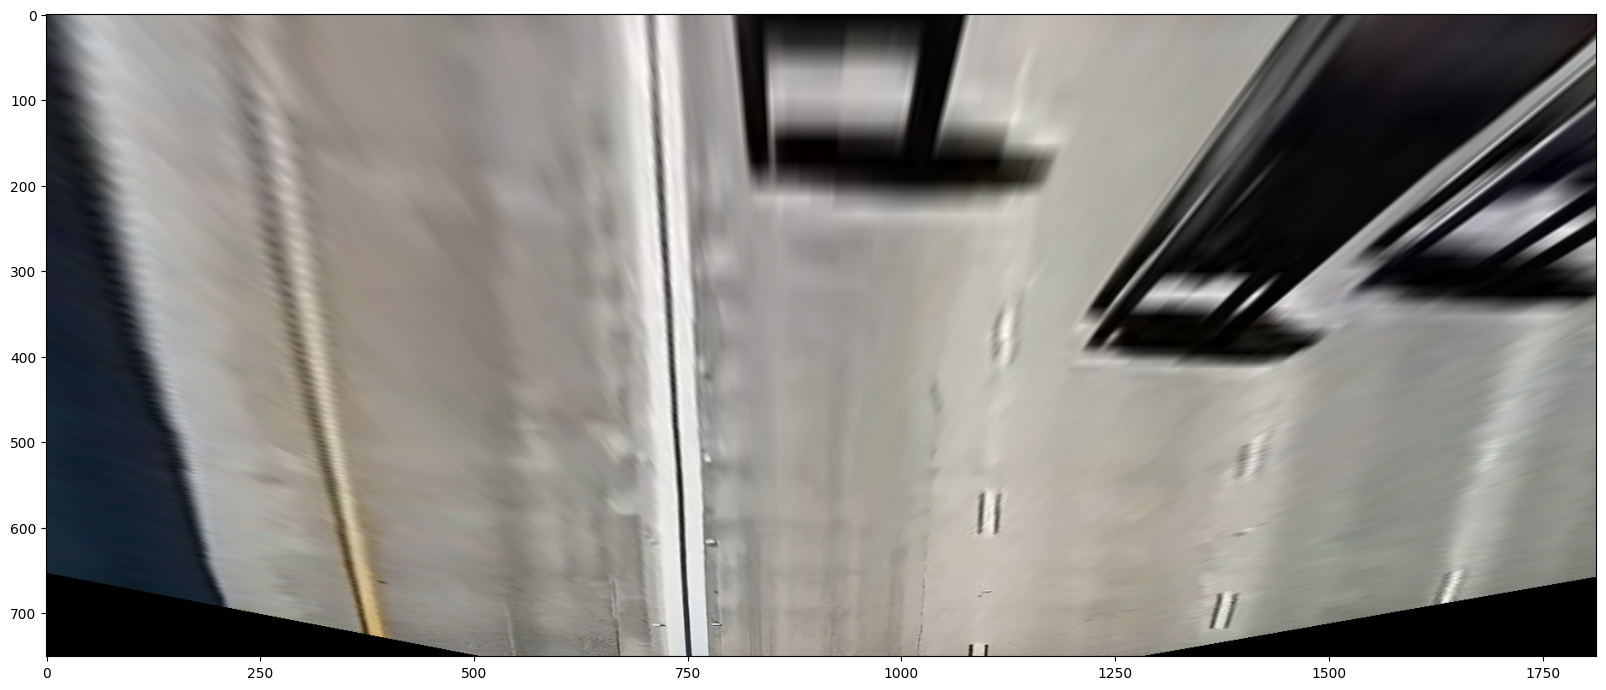

In [360]:
image_ = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

dst_pts = np.float32([(int(img_w*0.4), 0), 
                      (int(img_w*0.6), 0), 
                      (int(img_w*0.6), img_h), 
                      (int(img_w*0.4), img_h)
                    ])

no_perspective, M = remove_road_perspective(image, img_h, img_w, src_pts, dst_pts)

plt.figure(figsize=(20, 14))
plt.imshow(no_perspective)

Como se puede observar, la homografía ha rectificado las líneas de la carretera correctamente. La desventaja de este método, es que solo rectificará a la perfección imagenes tomadas con esta misma perspectiva. Para aplicar la homografía a cualquier imagen tomada desde una perspectiva distinta, es necesario pasar como parámetro los puntos de un rectángulo alineado con las líneas de carretera para dicha camara.

## Detección de líneas

Para detectar las líneas correctamente, debemos aplicar la supresión de la perspectiva a la imagen de bordes, para obtener la imagen de bordes sin perspectiva. De esta imagen, se puede obtener el polinomio que aproxima las rectas, para obtener la máscara del carril.

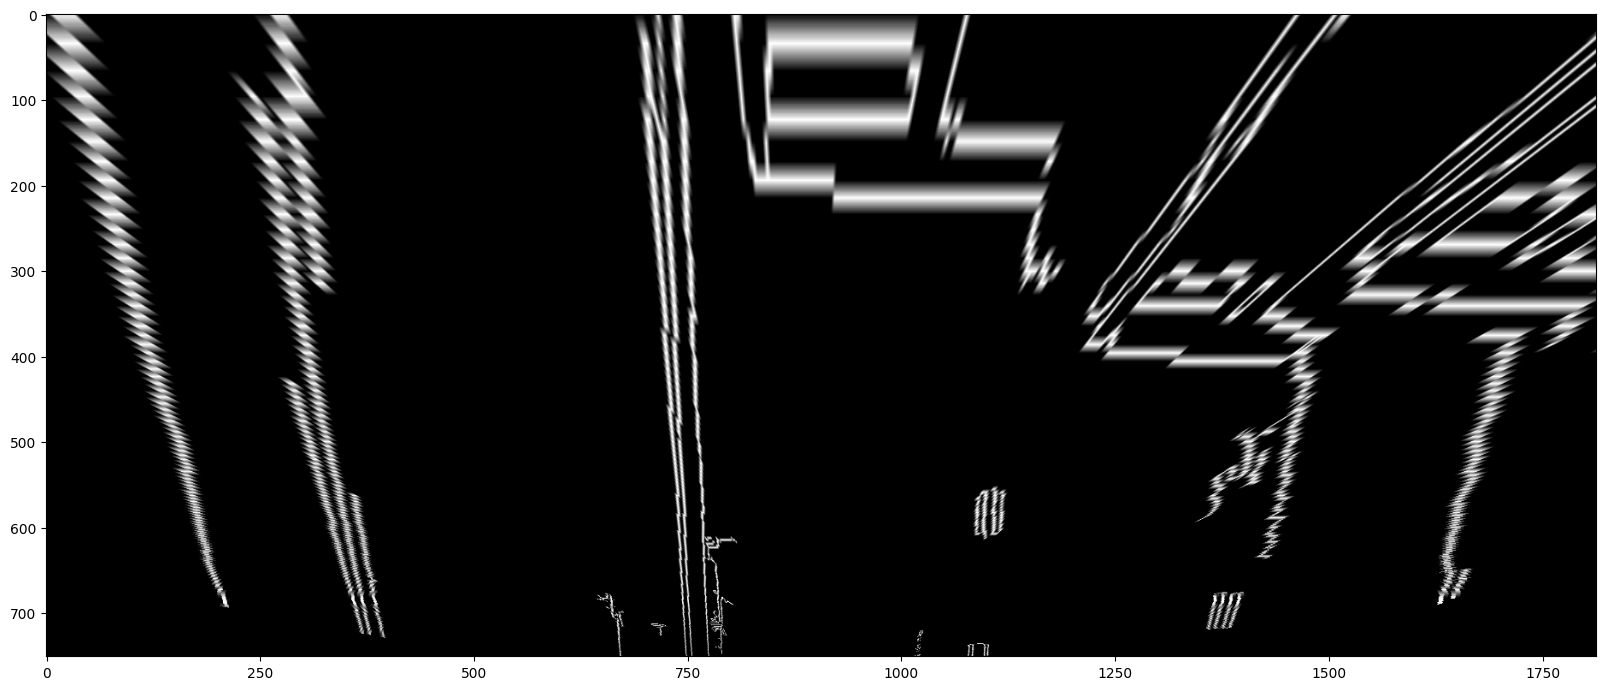

In [361]:
# Get the no perspective edges
no_perspective_edges, M = remove_road_perspective(edges, img_h, img_w, src_pts, dst_pts)

plt.figure(figsize=(20, 14))
plt.imshow(no_perspective_edges, cmap='gray')

A continuación se implementa una función que detecta el trazado de las líneas, utilizando dos ventanas deslizantes, cada una empezando en una línea. El punto de inicio de cada ventana deslizante viene dado por los dos picos que tendrá un histograma tomado de la sección inferior de la imagen. Cada pico corresponderá a una de las líneas.

In [362]:
def calculate_road_lines(binary_warped, draw_points=False, draw_windows=False, ):
    """ Calculate the road lines in a edges image with non perspective transformation applied, using sliding windows and polynomial fitting. 
        Then, draw the windows and the lines in an output image.
    
        Args:
            binary_warped: The binary image with the road lines in white
        Returns:
            left_fit: The polynomial coefficients for the left road line
            right_fit: The polynomial coefficients for the right road line
            out_img: The output image with the detected lines and windows drawn
    """  
    img_h, img_w = binary_warped.shape[:2]

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(img_h*0.8):int(img_h*0.98),int(img_w*0.35):int(img_w*0.65)], axis=0)

    # The peak of the left and right halves of the histogram will be the starting point for the left and right lines
    mid_point = histogram.shape[0]//2
    left_peak = np.argmax(histogram[:mid_point]) + int(img_w*0.35)
    right_peak = np.argmax(histogram[mid_point:]) + mid_point + int(img_w*0.35)

    if left_peak == 0 or right_peak == 0:
        return None, None, None

    # Set parameters for sliding windows
    nwindows = 9
    window_height = int(img_h // nwindows)
    margin = img_w // 20
    minpix = 50
    left_current = left_peak 
    right_current = right_peak
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    out_img = None

    if draw_windows:
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Slide windows from bottom to top, finding line pixels
    for window in range(nwindows):
        # Define new window
        win_y_low = img_h - window * window_height
        win_y_high = img_h - (window + 1) * window_height
        win_xleft_low = left_current - margin
        win_xleft_high = left_current + margin
        win_xright_low = right_current - margin
        win_xright_high = right_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = (binary_warped[win_y_high:win_y_low, win_xleft_low:win_xleft_high]).nonzero()
        good_right_inds = (binary_warped[win_y_high:win_y_low, win_xright_low:win_xright_high]).nonzero()

        # Adjust pixels to image coordinates
        good_left_inds = (good_left_inds[0] + win_y_high, good_left_inds[1] + win_xleft_low)
        good_right_inds = (good_right_inds[0] + win_y_high, good_right_inds[1] + win_xright_low)

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        new_left_current = left_current
        new_right_current = right_current

        # If found > minpix pixels, recenter next window on their mean position (ponderated to center of the image)
        if len(good_left_inds[0]) > minpix:
            new_left_current = int(np.mean(good_left_inds[1]))
        if len(good_right_inds[0]) > minpix:
            new_right_current = int(np.mean(good_right_inds[1]))

        # Check wether boxes colides
        left_box_right_edge = new_left_current + margin
        right_box_left_edge = new_right_current - margin
        buffer = 10 
        
        # If no colision, we let the means
        if right_box_left_edge > (left_box_right_edge + buffer):
            
            left_current = new_left_current
            right_current = new_right_current

        # Else, we dont renew them
        else:
            pass

        if draw_windows:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,
                          (left_current - margin, win_y_high), 
                          (left_current + margin, win_y_low),
                          (0,255,0), 2)
            cv2.rectangle(out_img,
                          (right_current - margin, win_y_high), 
                          (right_current + margin, win_y_low),
                          (0,255,0), 2)

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds, axis=1)
    right_lane_inds = np.concatenate(right_lane_inds, axis=1)

    if (len(left_lane_inds[0]) == 0) | (len(right_lane_inds[0]) == 0):
        return None, None, None

    if draw_points:
        # Draw lane pixels
        out_img[left_lane_inds[0], left_lane_inds[1]] = [255, 0, 0]
        out_img[right_lane_inds[0], right_lane_inds[1]] = [0, 0, 255]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(left_lane_inds[0], left_lane_inds[1], 1)
    right_fit = np.polyfit(right_lane_inds[0], right_lane_inds[1], 1)

    return left_fit, right_fit, out_img

A continuación se calcula el trazado de las líneas de la imagen de bordes con la perspectiva corregida.

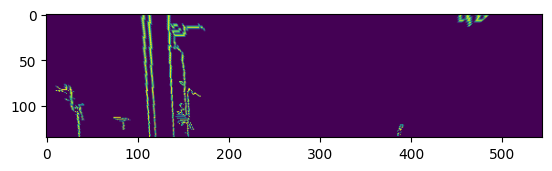

In [363]:
plt.imshow(no_perspective_edges[int(img_h*0.8):int(img_h*0.98),int(img_w*0.35):int(img_w*0.65)])

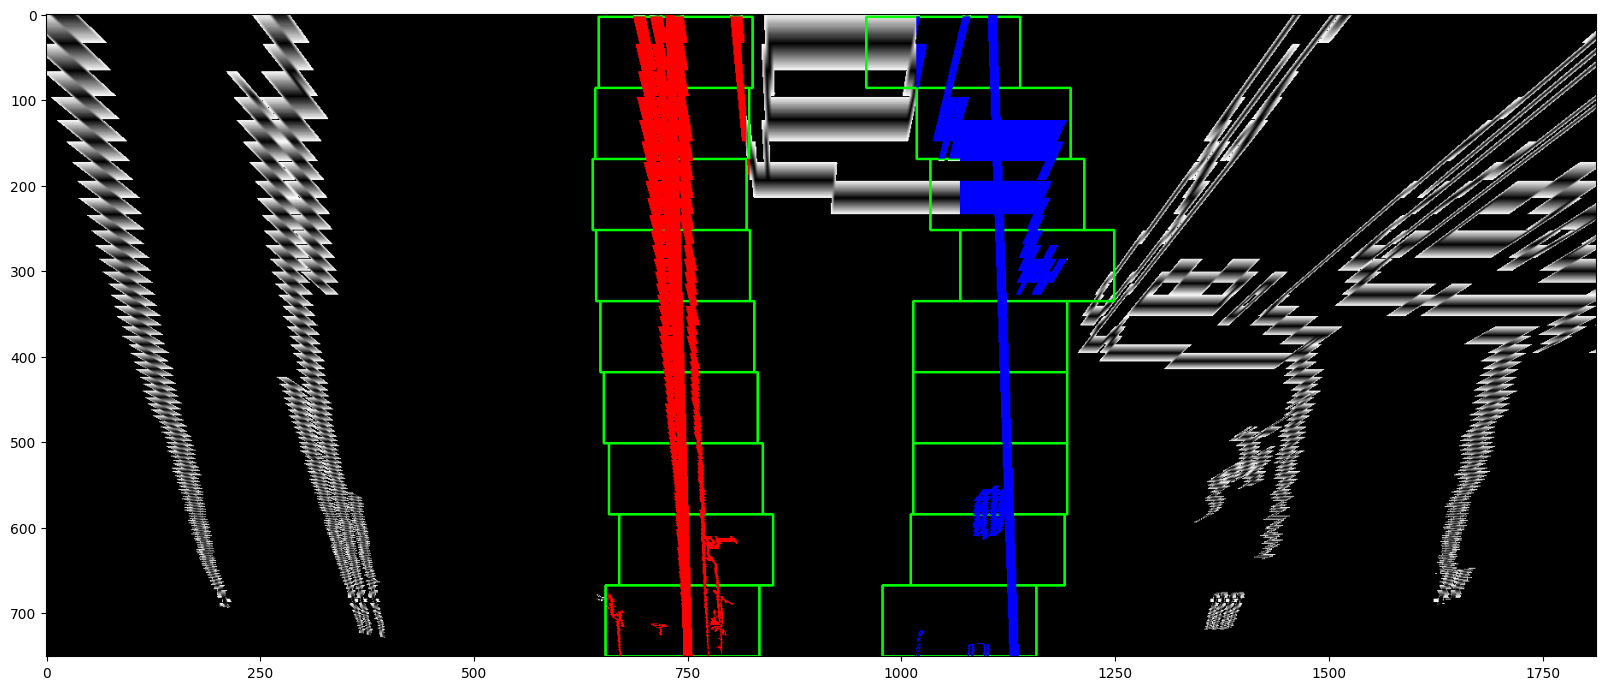

In [364]:
left_fit_edges, right_fit_edges, no_perspective_lines_edges = calculate_road_lines(no_perspective_edges, draw_points=True, draw_windows=True)

if left_fit_edges is None or right_fit_edges is None:
    print("Could not detect both lane lines.")
else:
    # Generate x and y values for plotting
    ploty = np.linspace(0, no_perspective_lines_edges.shape[0]-1, no_perspective_lines_edges.shape[0])
    left_fitx = np.polyval(left_fit_edges, ploty)
    right_fitx = np.polyval(right_fit_edges, ploty)

    # Draw the lane onto the output image
    for i in range(len(ploty)-1):
        cv2.line(no_perspective_lines_edges, (int(left_fitx[i]), int(ploty[i])), (int(left_fitx[i+1]), int(ploty[i+1])), (255, 0, 0), 10)
        cv2.line(no_perspective_lines_edges, (int(right_fitx[i]), int(ploty[i])), (int(right_fitx[i+1]), int(ploty[i+1])), (0, 0, 255), 10)

    plt.figure(figsize=(20, 14))
    plt.imshow(no_perspective_lines_edges)



## Transformación inversa

Por último, se debe regresar a la perspectiva original, y aplicar la máscara de segmentación del carril. Para se debe aplicar la inversa de la matriz de homografía a las rectas calculadas, y entre ellas se crea la máscara final del carril.

A continuación se implementa una función que calcula la máscara de las líneas y las dibuja en la imagen original con la perspectiva aplicada.

In [380]:
def get_road_mask(no_perspective_image, left_fit, right_fit, Minv, h_img, img_w):
    """
        Create the mask of the detected road area
    """
    
    # Calculate left and right lanes
    ploty = np.linspace(0, h_img-1, h_img)
    left_fitx = np.polyval(left_fit, ploty)
    right_fitx = np.polyval(right_fit, ploty)
    
    # Create empty RGB image to draw the mask
    warp_zero = np.zeros_like(no_perspective_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Set format to points for cv2.fillpoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the mask on the empty image, this will be the mask
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0)) # Verde

    # Apply inverse homography to the road mask
    road_mask = cv2.warpPerspective(color_warp, Minv, (img_w, h_img)) 

    return road_mask

Ahora dibujamos la máscara del carril sobre la imagen original

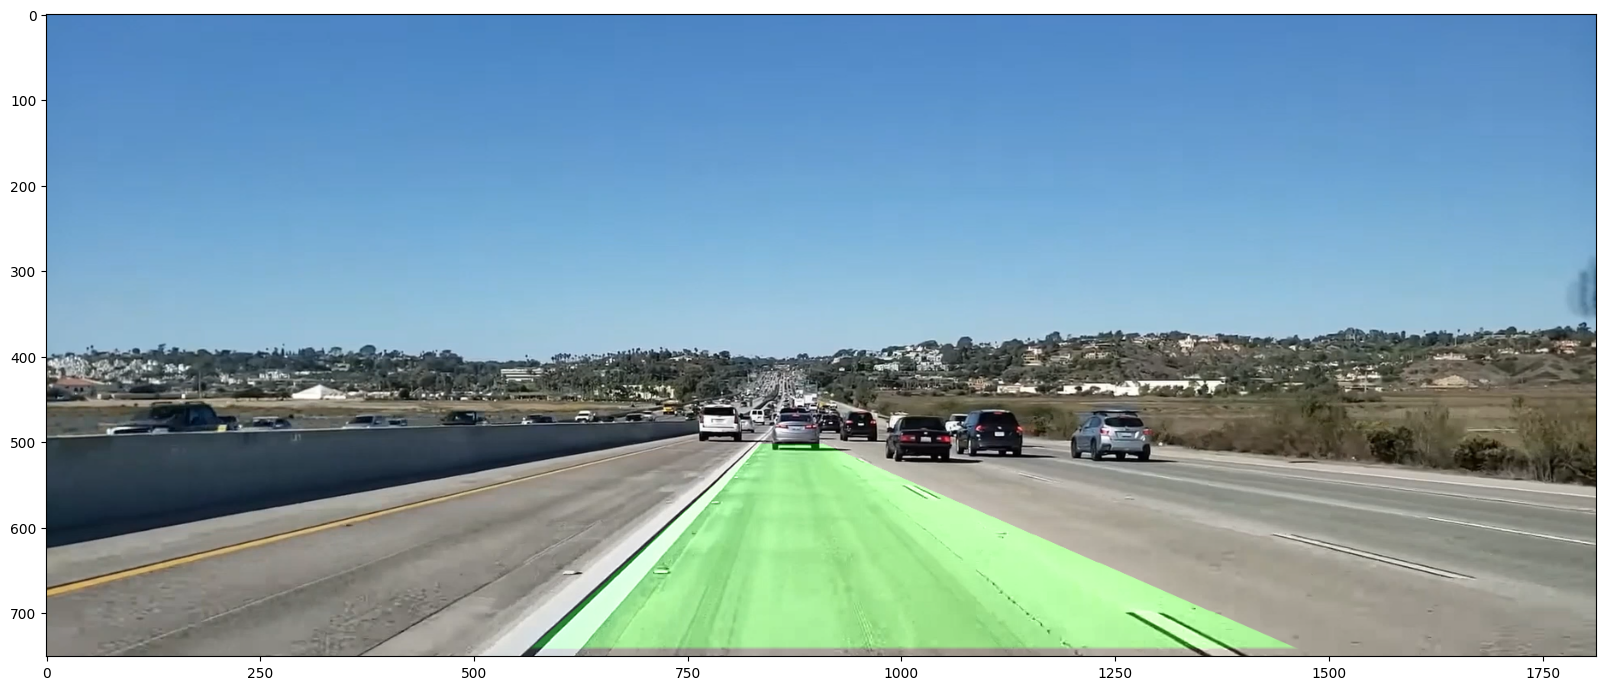

In [ ]:
Minv = np.linalg.inv(M)

if left_fit_edges is not None and right_fit_edges is not None:
    road_mask_edges = get_road_mask(no_perspective_edges, left_fit_edges, right_fit_edges, Minv, img_h, img_w)

    # Draw the mask on the original image
    final_image_edges = cv2.addWeighted(image, 1, road_mask_edges, 0.3, 0)

    plt.figure(figsize=(20, 14))
    plt.imshow(final_image_edges)

Se puede observar que el carríl se desvía ligeramente en la línea discontinua, sin embargo, esto no supone un problema para el objetivo de calcular la distancia, ya que sí detectaría correctamente que el vehículo se encuentra en el carril.

## Predicción en vídeo

Ya se ha demostrado el funcionamiento del modelo en imágenes. Ahora se procede a calcular las predicciones para una secuencia de vídeo entera.

In [ ]:
def process_lines_video(video_path, output_path, check_path, 
                        src_pts = np.float32([
                                            (int(img_w * 0.46), int(img_h * 0.67)), 
                                            (int(img_w * 0.50), int(img_h * 0.67)), 
                                            (int(img_w * 0.75), int(img_h * 0.99)), 
                                            (int(img_w * 0.28), int(img_h * 0.99))
                        ]), 
                        dst_pts = np.float32([(int(img_w*0.4), 0), 
                                            (int(img_w*0.6), 0), 
                                            (int(img_w*0.6), img_h), 
                                            (int(img_w*0.4), img_h)
                        ])):
    """
        This functions processes a video by segmenting the own line of the vehicle.

    Args:
        video_path: The path to the video file
        output_path: The path where the resulting video is written

    Returns:
        true if video is correctly processed, False if an error ocurred.
    """
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return False
    else:
        # Create Writer with same properties that the original video
        img_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        img_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
        out = cv2.VideoWriter(output_path, fourcc, fps, (img_w, img_h))
        out_check = cv2.VideoWriter(check_path, fourcc, fps, (img_w, img_h))
        
        print(f"Processing video... Resolution: {img_w}x{img_h}, FPS: {fps}")
        
        # Calculate homography
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        Minv = np.linalg.inv(M)
        
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break # Video ended

            frame_processed = frame

            # Apply Canny
            edges_frame = image_edges(frame, lower_threshold=5, upper_threshold=250)

            # Remove perspective
            no_perspective_frame = cv2.warpPerspective(edges_frame, M, (img_w, img_h), flags=cv2.INTER_LINEAR)

            # Calculate road lines
            left_fit, right_fit, no_perspective_lines = calculate_road_lines(no_perspective_frame, draw_points=True, draw_windows=True)

            if left_fit is not None and right_fit is not None:
                road_mask = get_road_mask(no_perspective_frame, left_fit, right_fit, Minv, img_h, img_w)
                # Draw the mask on the original image
                frame_processed = cv2.addWeighted(frame, 1, road_mask, 0.3, 0)

            out.write(frame_processed)
            out_check.write(no_perspective_lines)
            
            # Show the frame processing in real time
            cv2.imshow("Processed video", frame_processed)
            
            frame_count += 1
            if frame_count % 50 == 0:
                print(f"{frame_count} frames processed...")

            # Exit if press 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        # Liberar recursos
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        return True

Finalmente, se procede a mostrar el resultado de aplicar el procesado, a un video de conducción por una autovía de GTA V. Se despliega también una ventana donde se puede ver el procesado de cada frame a tiempo real

In [368]:
# Get the video capture
video_name = "video1_recortado"
video_path = os.path.join(PATH_VIDEOS, f"{video_name}.mp4")
output_path = os.path.join(PATH_RESULT_VIDEOS,f"{video_name}_result_edges.mp4")
check_path = os.path.join(PATH_RESULT_VIDEOS, f"{video_name}_wraped_edges.mp4")

result = process_lines_video(video_path, output_path, check_path, src_pts=src_pts, dst_pts=dst_pts)

if result:
    print(f"Video saved in: {output_path}")
else:
    print("An error ocurred while openning the video.")

Processing video... Resolution: 1814x836, FPS: 30.0
50 frames processed...
100 frames processed...
150 frames processed...
200 frames processed...
250 frames processed...
Video saved in: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/road_segmentation/videos\video1_recortado_result_edges.mp4


# METODO CON FILTRADO

## Filtro de líneas de imagen

El primer paso es filtrar los posibles píxeles que puedan ser líneas de carretera. Estas serán de los elementos de la imagen con mayor gradiente en el eje X, ya que el contraste de color entre las líneas y el asfalto suele ser muy elevado, y su dirección es vertical en la imagen.

Se va a trabajar la imagen en el espacio HLS, que diferencia entre tonalidad de color (H), luminosidad (L) y saturación del color (S). Este espacio es ideal ya que permite manejar por separado ciertas propiedades fundamentales de las líneas de la carretera:
1. Suelen de color blanco o amarillo. El blanco tiene una luminosidad muy alta, y el amarillo tiene un valor de tonalidad de 15-35 en el canal Hue.
2. Son vérticales en la imagen, por lo que tienen un alto gradiente de intensidad en el eje X, y bajo en el eje Y.

A continuación se implementa una función que detecta las líneas en función de varias las propiedades mencionadas anteriormente.

In [369]:
def road_line_filter_image(image, saturation_thresh=(170, 255), sobelx_thresh=(20, 100)):
    """ Filter the road lines in the image using color and gradient thresholds.
    
        Args:
            image: Input image to be filtered
            saturation_thresh: Saturation threshold
            sobelx_thresh: Sobel x threshold
        Returns: 
            combined_binary: Binary image after applying the filters
    """
    # Transform to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(float)
    h_channel = hls[:,:,0] # Hue channel
    l_channel = hls[:,:,1] # Lightness channel
    s_channel = hls[:,:,2] # Saturation channel

    # Filter white pixels (Hihg luminosity)
    white_mask = np.zeros_like(l_channel)
    white_mask[(l_channel > 220) & (l_channel <= 255)] = 1

    # Filter yellow pixels (High saturation + Hue: 15 - 35)
    yellow_mask = np.zeros_like(s_channel)
    yellow_mask[((h_channel >= 15) & (h_channel <= 35)) & 
                ((s_channel > saturation_thresh[0]) & (s_channel <= saturation_thresh[1]))] = 1
    
    # Sobel X: vertical edges
    l_blur = cv2.GaussianBlur(l_channel, (5,5), 1)
    sobel_x = cv2.Sobel(l_blur, cv2.CV_64F, 1, 0)
    abs_sobel_x = np.absolute(sobel_x)
    scaled_sobel = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
    
    sobelx_mask = np.zeros_like(scaled_sobel)
    sobelx_mask[(scaled_sobel >= sobelx_thresh[0]) & (scaled_sobel <= sobelx_thresh[1])] = 1
    
    # Create final mask
    color_binary = np.dstack((np.zeros_like(sobelx_mask), sobelx_mask, (yellow_mask==1) | (white_mask==1))) * 255
    
    combined_binary = np.zeros_like(sobelx_mask)
    combined_binary[(yellow_mask == 1) | (white_mask == 1) | (sobelx_mask == 1)] = 1

    # Eliminate car hood from image
    #h, _ = combined_binary.shape
    #hood_height = int(h * 0.05) # Around 5% of bottom pixels belongs to the hood
    #combined_binary[h-hood_height:h, :] = 0
    
    return combined_binary, color_binary

A continuación se aplica el filtro de líneas a la imagen de muestra

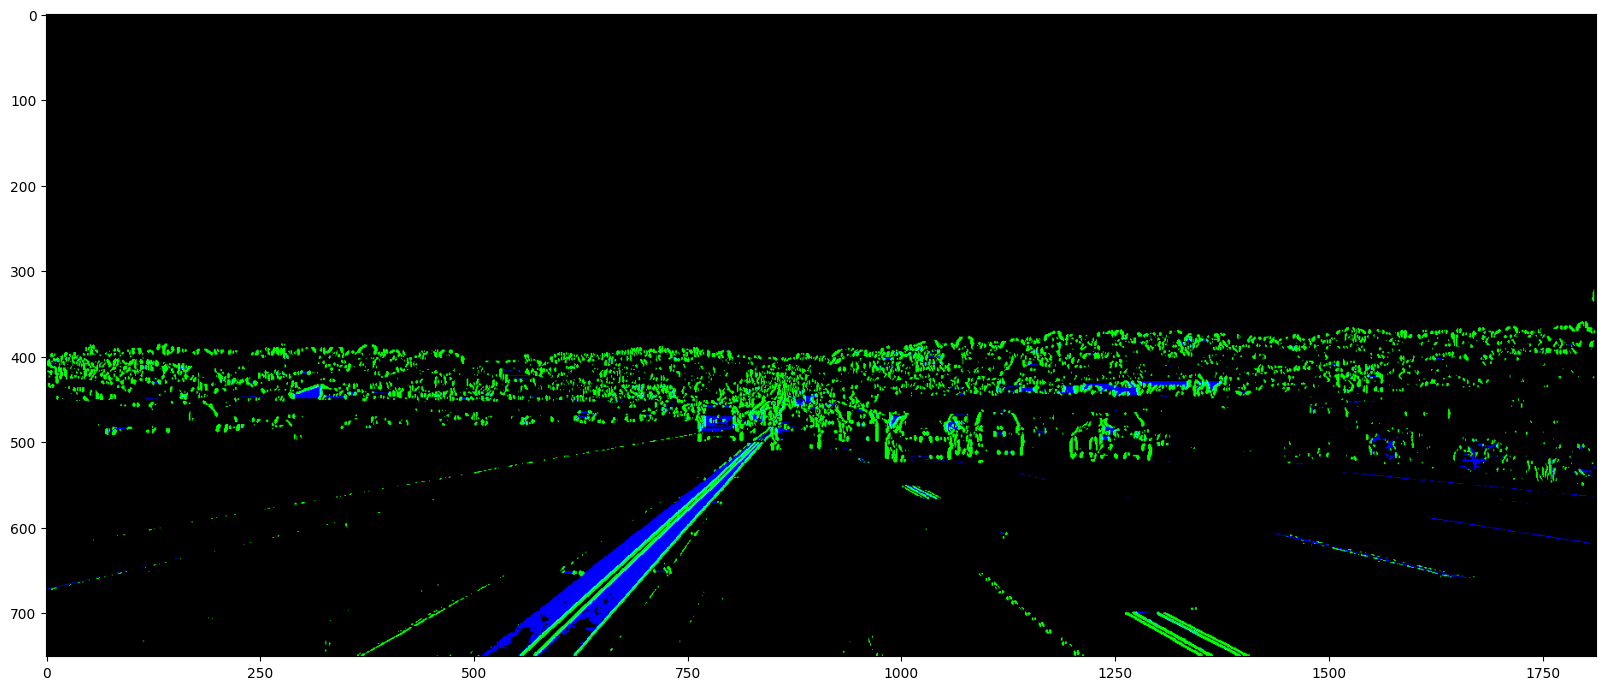

In [370]:
filter_image, visualizacion = road_line_filter_image(image, sobelx_thresh=(30,255))

plt.figure(figsize=(20, 14))
plt.imshow(visualizacion)

## Eliminar perspectiva

DEFINIDO YA

## Detección de líneas

Para detectar las líneas correctamente, debemos aplicar la supresión de la perspectiva a la imagen con el filtro de líneas, para obtener la misma sin perspectiva. De esta imagen, se puede obtener el polinomio que aproxima las rectas, para obtener la máscara del carril.

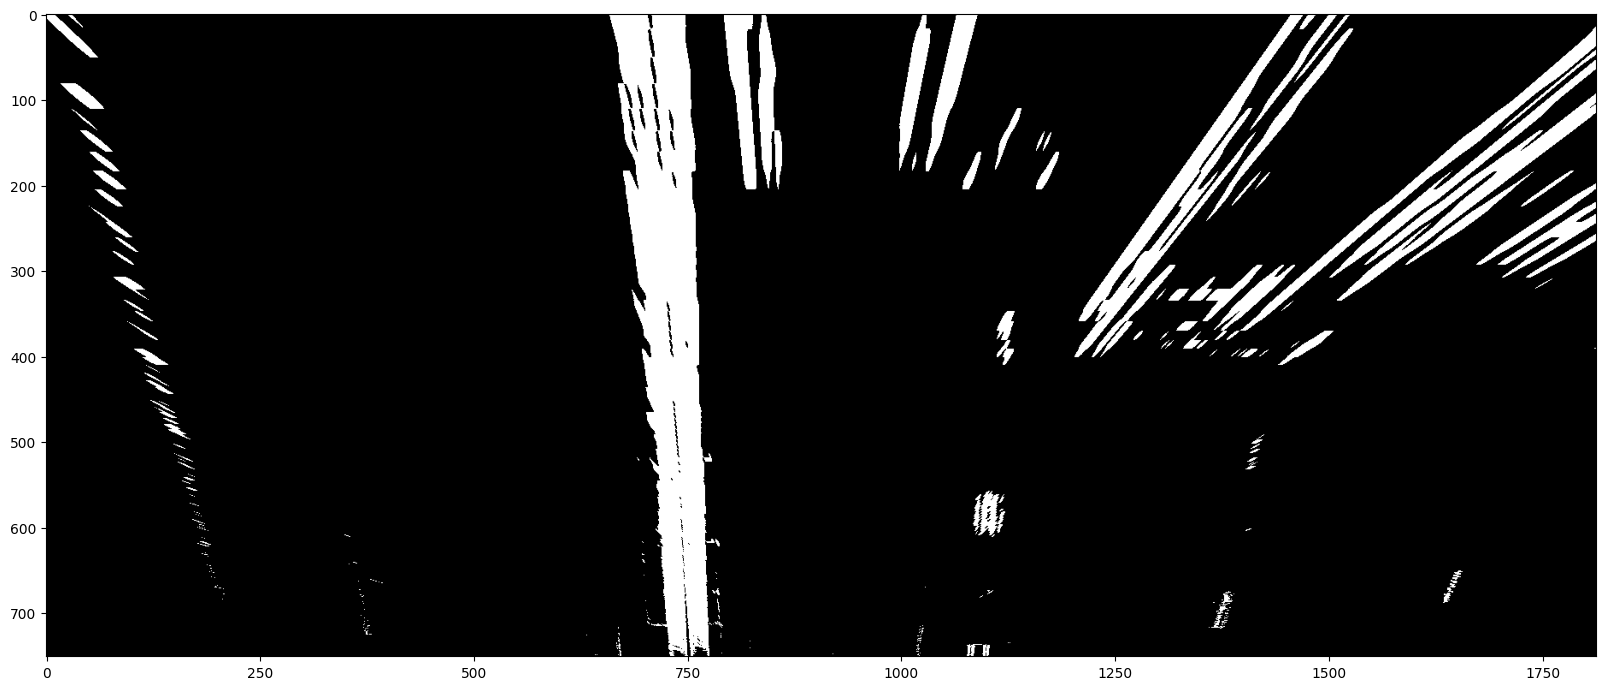

In [371]:
# Get the no perspective edges
no_perspective_filter, M = remove_road_perspective(filter_image, img_h, img_w, src_pts, dst_pts)

plt.figure(figsize=(20, 14))
plt.imshow(no_perspective_filter, cmap='gray')

A continuación se implementa una función que detecta el trazado de las líneas, utilizando dos ventanas deslizantes, cada una empezando en una línea. El punto de inicio de cada ventana deslizante viene dado por los dos picos que tendrá un histograma tomado de la sección inferior de la imagen. Cada pico corresponderá a una de las líneas.

    def calculate_road_lines(binary_warped, draw_points=False, draw_windows=False):
        ...
        return left_fit, right_fit, out_img

A continuación se calcula el trazado de las líneas de la imagen de filtro de líneas con la perspectiva corregida.

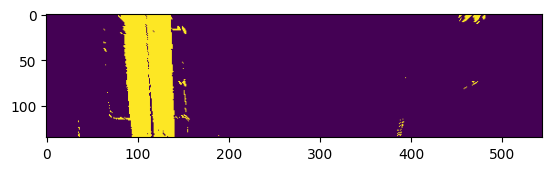

In [372]:
plt.imshow(no_perspective_filter[int(img_h*0.8):int(img_h*0.98),int(img_w*0.35):int(img_w*0.65)])

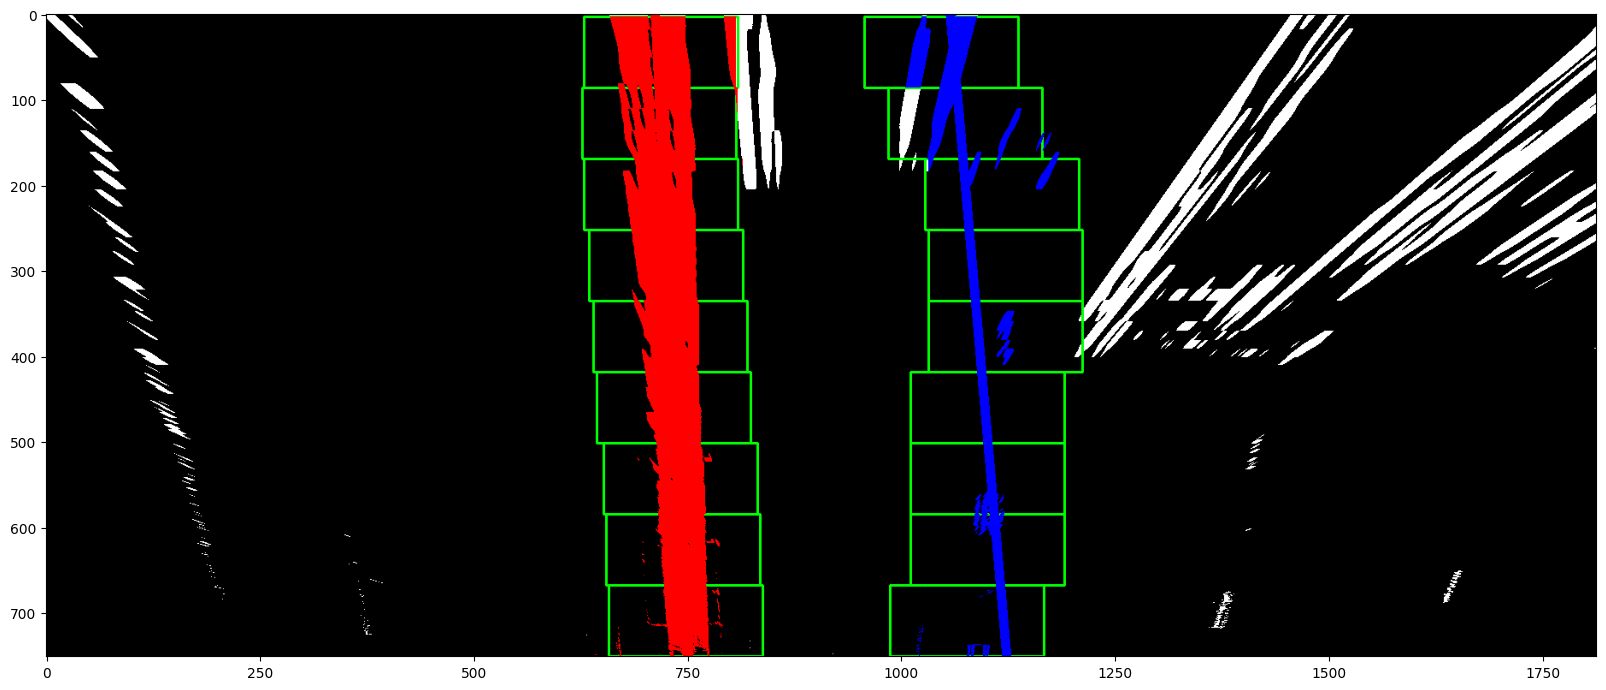

In [373]:
left_fit_filter, right_fit_filter, no_perspective_lines_filter = calculate_road_lines(no_perspective_filter, draw_points=True, draw_windows=True)

if no_perspective_lines_filter is None:
    print("Could not detect both lane lines.")
else:
    # Generate x and y values for plotting
    ploty = np.linspace(0, no_perspective_lines_filter.shape[0]-1, no_perspective_lines_filter.shape[0])
    left_fitx = np.polyval(left_fit_filter, ploty)
    right_fitx = np.polyval(right_fit_filter, ploty)

    # Draw the lane onto the output image
    for i in range(len(ploty)-1):
        cv2.line(no_perspective_lines_filter, (int(left_fitx[i]), int(ploty[i])), (int(left_fitx[i+1]), int(ploty[i+1])), (255, 0, 0), 10)
        cv2.line(no_perspective_lines_filter, (int(right_fitx[i]), int(ploty[i])), (int(right_fitx[i+1]), int(ploty[i+1])), (0, 0, 255), 10)

    plt.figure(figsize=(20, 14))
    plt.imshow(no_perspective_lines_filter)

## Transformación inversa

Por último, se debe regresar a la perspectiva original, y aplicar la máscara de segmentación del carril. Para se debe aplicar la inversa de la matriz de homografía a las rectas calculadas, y entre ellas se crea la máscara final del carril.

A continuación se implementa una función que calcula la máscara de las líneas y las dibuja en la imagen original con la perspectiva aplicada.

    def road_line_filter_image(image, saturation_thresh=(170, 255), sobelx_thresh=(20, 100)):
        ...
        return combined_binary, color_binary

Ahora dibujamos la máscara del carril sobre la imagen original

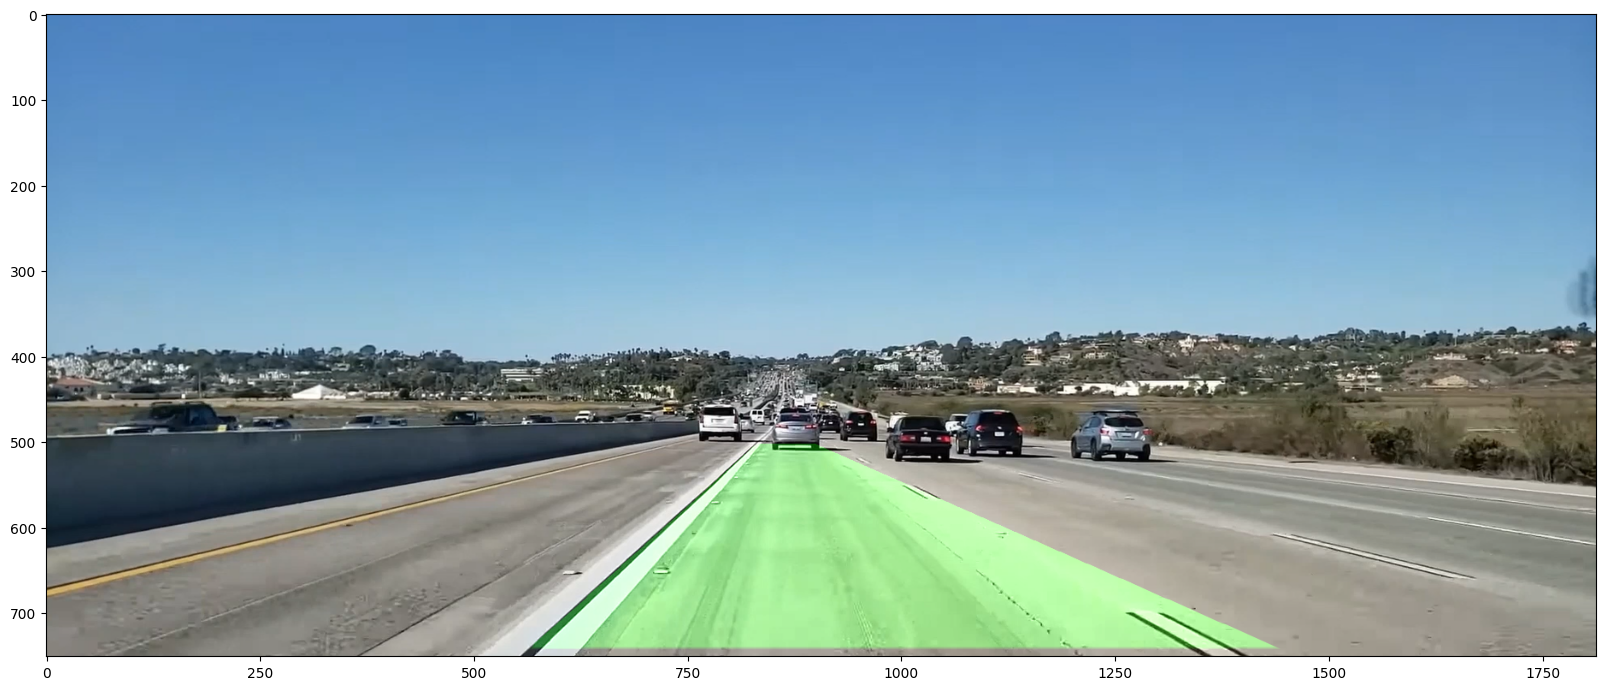

In [ ]:
Minv = np.linalg.inv(M)

if left_fit_filter is not None and right_fit_filter is not None:
    road_mask_filter = get_road_mask(no_perspective_filter, left_fit_filter, right_fit_filter, Minv, img_h, img_w)
    # Draw the mask on the original image
    final_image_filter = cv2.addWeighted(image, 1, road_mask_filter, 0.3, 0)

    plt.figure(figsize=(20, 14))
    plt.imshow(final_image_filter)

## Predicción en vídeo

Ya se ha demostrado el funcionamiento del modelo en imágenes. Ahora se procede a calcular las predicciones para una secuencia de vídeo entera.

In [395]:
def process_lines_video(video_path, output_path, check_path, 
                        src_pts = np.float32([
                                            (int(img_w * 0.46), int(img_h * 0.67)), 
                                            (int(img_w * 0.50), int(img_h * 0.67)), 
                                            (int(img_w * 0.75), int(img_h * 0.99)), 
                                            (int(img_w * 0.28), int(img_h * 0.99))
                        ]), 
                        dst_pts = np.float32([(int(img_w*0.4), 0), 
                                            (int(img_w*0.6), 0), 
                                            (int(img_w*0.6), img_h), 
                                            (int(img_w*0.4), img_h)
                        ])):
    """
        This functions processes a video by segmenting the own line of the vehicle.

    Args:
        video_path: The path to the video file
        output_path: The path where the resulting video is written

    Returns:
        true if video is correctly processed, False if an error ocurred.
    """
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return False
    else:
        # Create Writer with same properties that the original video
        img_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        img_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        fps = cap.get(cv2.CAP_PROP_FPS)
        fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
        out = cv2.VideoWriter(output_path, fourcc, fps, (img_w, img_h))
        out_check = cv2.VideoWriter(check_path, fourcc, fps, (img_w, img_h))
        
        print(f"Processing video... Resolution: {img_w}x{img_h}, FPS: {fps}")
        
        # Calculate homography
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        Minv = np.linalg.inv(M)
        
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break # Video ended

            frame_processed = frame

            # Filter potential line pixels
            filter_frame, _ = road_line_filter_image(frame, sobelx_thresh=(20,100))

            # Remove perspective
            no_perspective_frame = cv2.warpPerspective(filter_frame, M, (img_w, img_h), flags=cv2.INTER_LINEAR)

            # Calculate road lines
            left_fit, right_fit, no_perspective_lines = calculate_road_lines(no_perspective_frame, draw_points=True, draw_windows=True)

            if left_fit is not None and right_fit is not None:
                road_mask = get_road_mask(no_perspective_frame, left_fit, right_fit, Minv, img_h, img_w)
                
                # Draw the mask on the original image
                frame_processed = cv2.addWeighted(frame, 1, road_mask, 0.3, 0)

                if frame_count == 0:
                    plt.imshow(frame_processed)

            out.write(frame_processed)
            out_check.write(no_perspective_lines)
            
            # Show the frame processing in real time
            cv2.imshow("Processed video", frame_processed)
            
            frame_count += 1
            if frame_count % 50 == 0:
                print(f"{frame_count} frames processed...")

            # Exit if press 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        if frame_count == 0:
            print("Error, video has not been processed")

        # Liberar recursos
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        return True

Finalmente, se procede a mostrar el resultado de aplicar el procesado, a un video de conducción por una autovía de GTA V. Se despliega también una ventana donde se puede ver el procesado de cada frame a tiempo real

Processing video... Resolution: 1814x836, FPS: 30.0
50 frames processed...
100 frames processed...
150 frames processed...
200 frames processed...
250 frames processed...


C:\Users\gonza\AppData\Local\Temp\ipykernel_18240\504291736.py:113: RankWarning: Polyfit may be poorly conditioned
  left_fit = np.polyfit(left_lane_inds[0], left_lane_inds[1], 1)
C:\Users\gonza\AppData\Local\Temp\ipykernel_18240\504291736.py:113: RankWarning: Polyfit may be poorly conditioned
  left_fit = np.polyfit(left_lane_inds[0], left_lane_inds[1], 1)
C:\Users\gonza\AppData\Local\Temp\ipykernel_18240\504291736.py:113: RankWarning: Polyfit may be poorly conditioned
  left_fit = np.polyfit(left_lane_inds[0], left_lane_inds[1], 1)
C:\Users\gonza\AppData\Local\Temp\ipykernel_18240\504291736.py:113: RankWarning: Polyfit may be poorly conditioned
  left_fit = np.polyfit(left_lane_inds[0], left_lane_inds[1], 1)
C:\Users\gonza\AppData\Local\Temp\ipykernel_18240\504291736.py:114: RankWarning: Polyfit may be poorly conditioned
  right_fit = np.polyfit(right_lane_inds[0], right_lane_inds[1], 1)
C:\Users\gonza\AppData\Local\Temp\ipykernel_18240\504291736.py:113: RankWarning: Polyfit may be p

Video saved in: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/road_segmentation/videos\video1_recortado_result_filter.mp4


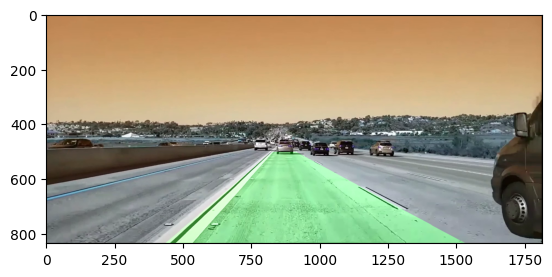

In [396]:
# Get the video capture
video_name = "video1_recortado"
video_path = os.path.join(PATH_VIDEOS, f"{video_name}.mp4")
output_path = os.path.join(PATH_RESULT_VIDEOS,f"{video_name}_result_filter.mp4")
check_path = os.path.join(PATH_RESULT_VIDEOS, f"{video_name}_wraped_filter.mp4")

result = process_lines_video(video_path, output_path, check_path, src_pts=src_pts, dst_pts=dst_pts)

if result:
    print(f"Video saved in: {output_path}")
else:
    print("An error ocurred while openning the video.")